In [1]:

import sys
path = "../../.."
if path not in sys.path:
    sys.path.insert(0, path)

import numpy as np
from data_retrieval import lipade_groundtruth
from data_retrieval.tools.data_loader import getDataLoader
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from clustering.clustering import getPredictionFromThreshold
import clustering.evaluators as evaluators
import csv

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

temperature = 0.5
batch_size = 512
workers = 2
corpus = "lipade_groundtruth"
resultsPath = "../results/distance/" + corpus + "/"
csv_filename = "results_ensembling.csv"


In [2]:
## Dataset
xSim,_,ySim = lipade_groundtruth.getDataset(mode = 'similar', uniform=True)
_,_,y_test = lipade_groundtruth.getDataset(mode="similar")

imagesSim = []
for i in range(len(xSim)):
    imagesSim.append(Image.open(xSim[i]).convert('RGB'))

testLoader = getDataLoader(imagesSim, None, None, False, batch_size, shuffle=False, num_workers=2)


In [ ]:
import torch.nn.functional as F

class FusionModel(nn.Module):
    def __init__(self, embed_dim=128, hidden_dim=256, out_dim=128):
        super(FusionModel, self).__init__()
        
        # Encoder MLP pour chaque embedding (partagé)
        self.encoder = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )
        
        # Attention weights : score par embedding
        self.attention = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Un score par embedding
        )
        
        # Projection finale
        self.project = nn.Sequential(
            nn.Linear(embed_dim, out_dim),
            nn.ReLU()
        )
    
    def forward(self, embeddings):
        """
        embeddings: Tensor shape [B, 21, D]
        Returns: fused embedding [B, out_dim]
        """
        B, N, D = embeddings.shape
        
        # Encode each embedding
        encoded = self.encoder(embeddings)  # [B, 21, D]
        
        # Compute attention weights
        attn_scores = self.attention(encoded)  # [B, 21, 1]
        attn_weights = F.softmax(attn_scores, dim=1)  # [B, 21, 1]
        
        # Weighted sum
        fused = torch.sum(attn_weights * encoded, dim=1)  # [B, D]
        
        # Final projection
        out = self.project(fused)  # [B, out_dim]
        return out


In [ ]:
## Representation de base
class SimCLR_Representation(nn.Module):
    def __init__(self, encoder, in_dim=2048, out_dim=128):
        super(SimCLR_Representation, self).__init__()
        self.encoder = encoder
        self.projection = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x_):
        h = self.encoder(x_)
        z = self.projection(h)
        return z
    

from sklearn.decomposition import PCA
# Ensembling 
class SimCLR_ensembling(nn.Module):
    def __init__(self, list_models, type_aggregation='mean', ponderation=None):
        super(SimCLR_ensembling, self).__init__()
        self.models = list_models
        self.type_aggregation = type_aggregation
        self.ponderation = ponderation
        self.pca = None
    
    def fit_PCA(self, embeddings):
        shape_output = self.models[0].projection[-1].out_features
        pca = PCA(n_components=shape_output)
        self.pca = pca.fit(embeddings)

    def forward(self, x_):
        shape_output = self.models[0].projection[-1].out_features
        z = torch.empty((len(self.models),x_.shape[0], shape_output)).to(device)

        for i, model in enumerate(self.models):
            z[i] = model(x_)
        
        if self.type_aggregation == 'mean':
            if self.ponderation is None:
                return torch.mean(z, dim=0)
            
            else:
                somme_ponderation = self.ponderation.sum()
                self.ponderation  = self.ponderation.view(-1, 1, 1)
                z *= self.ponderation
                z = z.sum(axis=0)/somme_ponderation
                return z
            
        elif self.type_aggregation == "concatenation":
            return z.view(x_.shape[0], shape_output*len(self.models))
        
        elif self.type_aggregation == "concatenation_reduction":
            # concatenation
            z_concat = z.view(x_.shape[0], shape_output*len(self.models)) 
            
            # reduction de dimensions
            if self.pca is None:
                self.fit_PCA(z_concat)
            
            pca_embeddings = self.pca.transform(z_concat)
            return pca_embeddings
        
        elif self.type_aggregation == "MLP":
            mlp = FusionModel()
            mlp.load_state_dict(torch.load(f'../fusion_model', map_location=torch.device('cpu'), weights_only=True))
            mlp.eval()
            return mlp(z)
        
        elif self.type_aggregation is None:
            return z
        
        else: 
            raise ValueError(f"Unknown type_aggregation: {self.type_aggregation}. Should be 'mean', 'concatenation', 'concatenation_reduction', 'MLP' or None.")


In [ ]:
def test(models, type_aggregation, ponderations, name_csv):
    ensemble = SimCLR_ensembling(list_models=models, 
                                 type_aggregation=type_aggregation, 
                                 ponderation=ponderations).to(device)
    
    ensemble.eval()

    representations = []
    with torch.no_grad():
        for batch in testLoader:
            batch_ens = ensemble(batch.to(device))
            for repr in batch_ens.tolist():
                representations.append(repr)

    sim = cosine_similarity(representations, representations)

    distance = 1 - (sim+1)/2
    distance -= np.diag(distance)

    method = f"simclr_ensemble"

    thresholds_precision = 1000
    thresholds = np.linspace(0, 1, thresholds_precision)

    precisions, recalls, f1s = evaluators.p_r_f1_byThresholds(thresholds, distance, y_test)
    f1 = np.max(f1s)
    AP, bestThresholdIndex = evaluators.pr_curve(precisions, recalls, f1s, other=("Fei mAP", evaluators.fei_mAP(y_test, distance)), save="evaluation/" + corpus + "/" + method + ".png")

    thresholdsClass = np.linspace(0, 1, int(thresholds_precision / 10))
    precisions_per_class, recalls_per_class = evaluators.p_r_class_byThresholds(thresholdsClass, distance, y_test)
    fei = evaluators.fei_mAP(y_test, distance)
    sam = evaluators.goncalves_mAP(precisions_per_class, recalls_per_class)


    # Création ou ouverture du fichier en mode append
    with open(csv_filename, mode="a", newline="") as file:
        writer = csv.writer(file)

        # Écrire l'en-tête si le fichier est vide
        if file.tell() == 0:
            writer.writerow(["trial_name", "ap", "fei", "sam", "f1"])

        # Écriture des résultats
        writer.writerow([name_csv, AP, fei, sam, f1])


In [72]:
list_models = []

paths = ["model_atkinson_dithering.pth", "model_contraste.pth", "model_sepia.pth", "model_bayer_halftoning.pth", "model_erased_element.pth",
         "model_crumpled_paper.pth", "model_bleedthrough.pth", "model_floyd_steinberg_halftoning.pth", "model_cadre.pth", "model_torn_paper.pth",
         "model_drawing.pth", "model_picture_overlay.pth", "model_folded_paper.pth", "model_text_overlay.pth", "model_salt_and_pepper_noise.pth", 
         "model_patchwork.pth",  
         "model_ink_bleed.pth", "model_dirty_rollers.pth", "model_gaussian_noise.pth", "model_paint.pth", "model_montage.pth"
        ]


ponderations = torch.tensor([0.43636, 0.435, 0.423, 0.41267, 0.410,
                             0.402, 0.38819, 0.383, 0.3816, 0.381,
                             0.373, 0.369, 0.368, 0.366, 0.365, 
                             0.360, 
                             0.352, 0.351, 0.334, 0.328, 0.326
                             ])

for path in paths:
    representationEncoder = resnet18(weights=ResNet18_Weights.DEFAULT)
    representationEncoder.fc = nn.Identity()
    model = SimCLR_Representation(representationEncoder, in_dim=512).to(device)
    model.load_state_dict(torch.load(f'../results/weights/simclr/{path}',map_location=torch.device('cpu'), weights_only=True))
    list_models.append(model)


Thresholds: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


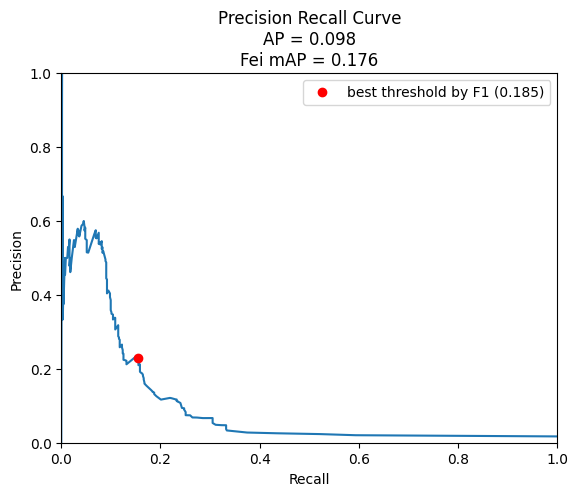

In [ ]:
test(list_models[:2], 'concatenation_reduction', None, "2_meilleurs_pca")